# Serotonin 3D GNN Project


This project builds upon research done by Łapińska et al. (2024): https://doi.org/10.3390/pharmaceutics16030349

Data used: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_35/

Move the unpacked chembl_35_sqlite.tar.gz file into the data/ dir.

The research linked above presents two Quantitative Structure-Activity Relationship (QSAR) models to predict serotonergic binding affinity and selectivity, respectively, using Mordred molecular 2D descriptors. Specifically, one model classifies compounds binarily as "active" or "inactive", with a cutoff of pKi = 7. Another model does multiclass classification to predict the serotonergic selectivity of compounds previously classified as "active".

I am following a similar approach, but using 3D molecular graph representations instead of 2D molecular descriptors as input modality and using only the ChEMBL database, not ZINC.


---

## Setup


### Configuration & Google Drive/Colab Sync


In [1]:
from pathlib import Path

try:
    from google.colab import drive

    drive.mount("/content/drive")
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"{'Running in Colab' if IN_COLAB else 'Running locally'}")

PATH_NOTEBOOK = (
    Path("/content/drive/MyDrive/Colab Notebooks/serotonin-3d-gnn.ipynb")
    if IN_COLAB
    else Path(
        "/Users/paul/Library/CloudStorage/GoogleDrive-unoutsch@gmail.com/My Drive/Colab Notebooks/serotonin-3d-gnn.ipynb"
    )
)
PATH_REPO = (
    Path("/content/drive/MyDrive/Repositories/serotonin-3d-gnn")
    if IN_COLAB
    else Path.cwd()
)
PATH_DATA = PATH_REPO / "data_fixed"
PATH_WEIGHTS = PATH_REPO / "weights"

Mounted at /content/drive
Running in Colab


### Installing Requirements


In [2]:
%pip install --requirement "$PATH_REPO/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports


In [3]:
import os
import sys
import time
import json
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, Descriptors, rdMolDescriptors, rdMolTransforms
import seaborn as sns
import shutil
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

### Syncing this file between Colab and local Git repo


Make sure the paths exist.


In [23]:
def copy_notebook():
    if IN_COLAB:
        shutil.copyfile(PATH_NOTEBOOK, PATH_REPO / "serotonin-3d-gnn.ipynb")
        print("Copied notebook to repo.")
    else:
        shutil.copyfile(PATH_REPO / "serotonin-3d-gnn.ipynb", PATH_NOTEBOOK)
        print("Copied notebook to Google Drive.")


copy_notebook()

Copied notebook to repo.


### Setting Torch Device


In [5]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


---

## Data Preprocessing


### Loading and Preprocessing Serotonin Data


If the pickled torch_data_list already exists, load it.


['/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_1a_3086.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_1b_466.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_1d_481.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_2b_833.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_2c_1385.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_4_338.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_6_2799.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_7_2317.csv', '/content/drive/MyDrive/Repositories/serotonin-3d-gnn/data_fixed/targets/serotonin_2a_2353.csv']
{'Serotonin 1a (5-HT1a) receptor': 0, 'Serotonin 1b (5-HT1b) receptor': 1, 'Serotonin 1d (5-HT1d) receptor': 2, 'Serotonin 2a (5-HT2a

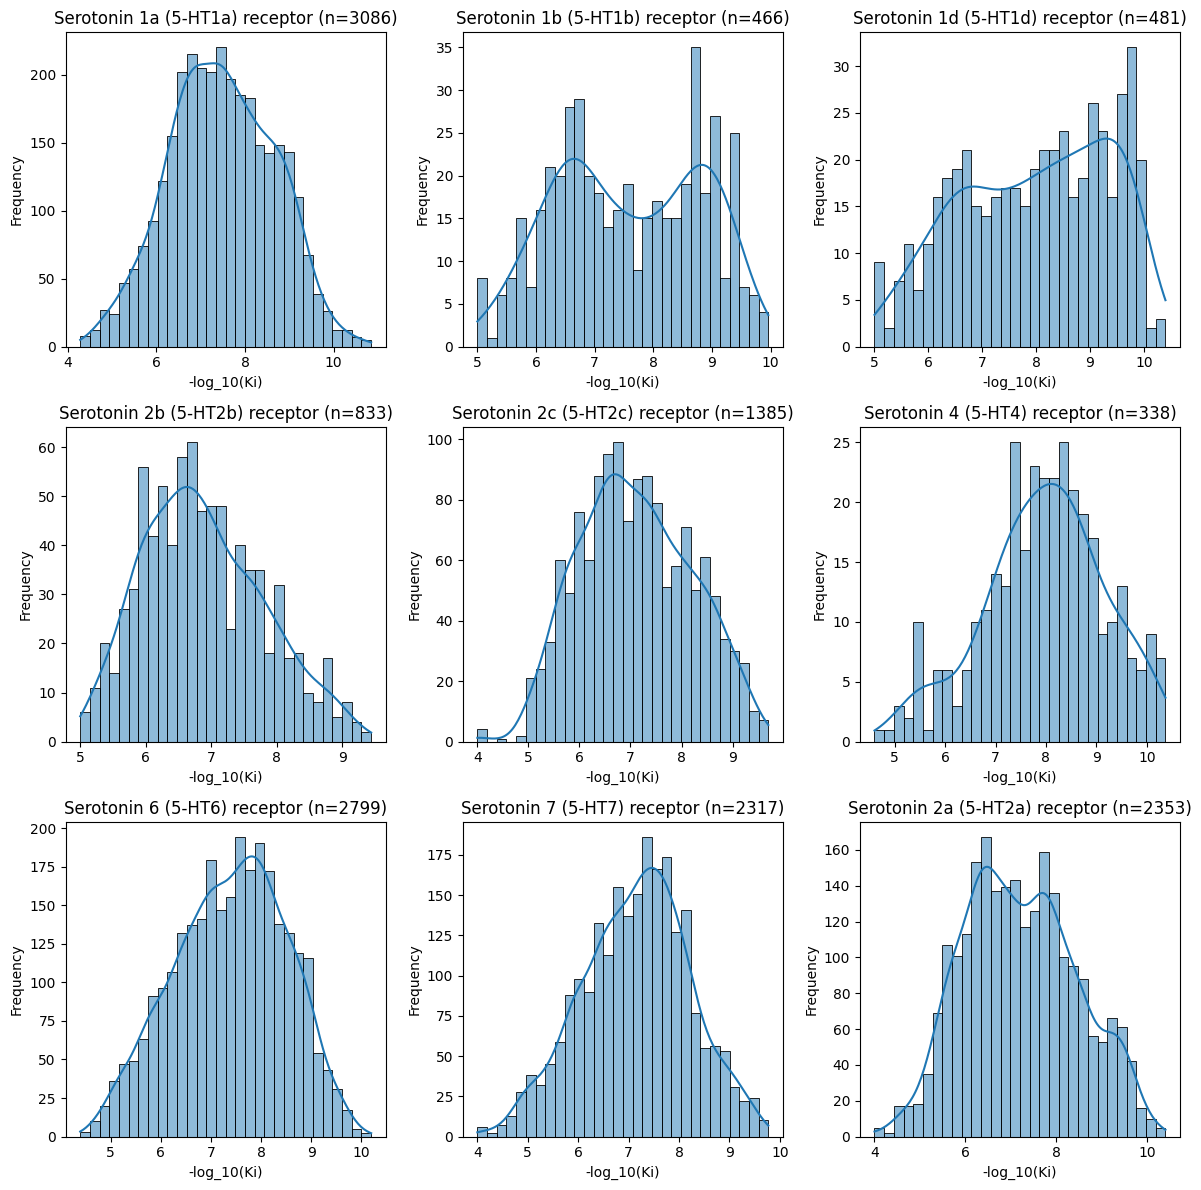

In [6]:
csv_files = glob(os.path.join(PATH_DATA / "targets" / "*.csv"))
print(csv_files)

data_list = []

for file in csv_files:
    df = pd.read_csv(
        file, delimiter=";", usecols=["Smiles", "pChEMBL Value", "Target Name"]
    )
    df.columns = ["smiles", "pchembl_value", "target_name"]
    data_list.append(df)

merged_df = pd.concat(data_list, ignore_index=True)
merged_df["target_name"] = merged_df["target_name"].astype("category")
merged_df["target_id"] = merged_df["target_name"].cat.codes

target_name_to_id = dict(
    zip(
        merged_df["target_name"].cat.categories,
        range(len(merged_df["target_name"].cat.categories)),
    )
)
target_id_to_name = {v: k for k, v in target_name_to_id.items()}
print(target_name_to_id)

merged_df.to_csv(os.path.join(PATH_DATA, "merged_serotonin_data.csv"), index=False)

merged_df.describe()

rows, cols = 3, 3  # 3 plots per row and col
num_targets = merged_df["target_name"].nunique()
target_names = merged_df["target_name"].unique()

# Create subplots in a 3x3 grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))

# Flatten axes array to handle iteration easily
axes = axes.flatten()

for i, target in enumerate(target_names):
    target_data = merged_df[merged_df["target_name"] == target]["pchembl_value"]
    target_count = merged_df["target_name"].value_counts()[target]

    sns.histplot(target_data, kde=True, bins=30, ax=axes[i])

    axes[i].set_title(f"{target} (n={target_count})")
    axes[i].set_xlabel("-log_10(Ki)")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [7]:
pickle_file_path = os.path.join(PATH_DATA, "merged_serotonin_data_processed.pkl")

if os.path.exists(pickle_file_path):
    print("Loading processed data...")
    with open(pickle_file_path, "rb") as f:
        merged_serotonin_data_processed = pickle.load(f)
    print("Done")
else:
    merged_serotonin_data_processed = None
    print("Will create new processed data.")

np.random.seed(42)
np.random.shuffle(merged_serotonin_data_processed)

Loading processed data...
Done


### Creating 3D Molecular Graph Data from Serotonin Data


In [8]:
periodic_table = rdchem.GetPeriodicTable()

ATOM_PROPERTIES = {
    atomic_num: [
        periodic_table.GetAtomicWeight(atomic_num),
        periodic_table.GetRvdw(atomic_num),
        periodic_table.GetDefaultValence(atomic_num),
    ]
    for atomic_num in range(1, 119)  # all elements in periodic table
}

BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
]


def create_torch_data(smiles: str, target_value: torch.Tensor, target_id) -> Data:
    # getting RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None

    # add explicit hydrogen atoms to the molecule (are not included in the SMILES string) so that its 3D structure is complete
    mol = Chem.AddHs(mol)
    Chem.SanitizeMol(mol)

    # EmbedMolecule positions atoms of mol in 3D space stochastically; if it fails (returning -1) return None
    if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
        return None

    # optimize the 3D structure using Universal Force Field (UFF) to lower mol's energy
    status = AllChem.UFFOptimizeMolecule(mol)
    if status == -1:
        print(f"UFF optimization failed for molecule: {smiles}")
        return None
    AllChem.UFFOptimizeMolecule(mol)

    # conformer contains 3D coordinates for mol's atoms
    conformer = mol.GetConformer()

    # molecule-level features
    mol_features = [
        Descriptors.ExactMolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
        rdMolDescriptors.CalcNumRotatableBonds(mol),
        rdMolDescriptors.CalcNumHBD(mol),
        rdMolDescriptors.CalcNumHBA(mol),
    ]

    # atom-level features and 3D positions
    atom_features, positions = [], []
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        atomic_mass, vdw_radius, valence = ATOM_PROPERTIES.get(
            atomic_num, [0.0, 0.0, 0]
        )

        features = [
            atomic_mass,
            vdw_radius,
            valence,
            atom.GetFormalCharge(),
            int(atom.GetIsAromatic()),
            atom.GetDegree(),
            int(atom.IsInRing()),
        ] + [
            1.0 if atom.GetHybridization() == h else 0.0
            for h in (
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
            )
        ]

        atom_features.append(features)

        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append([pos.x, pos.y, pos.z])

    # transform to PyTorch tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)

    # bonds between atoms – indices of connected atoms as well as types and conjugation
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        # indices of bonded atoms
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

        # one-hot encode bond type
        bond_type = bond.GetBondType()
        bond_type_one_hot = [1.0 if bond_type == b else 0.0 for b in BOND_TYPES]

        # is_conjugated = 1.0 if bond.GetIsConjugated() else 0.0
        bond_length = rdMolTransforms.GetBondLength(conformer, i, j)

        bond_feat = bond_type_one_hot + [bond_length]

        # adding bond to both nodes
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feat, bond_feat]

    # transform to PyTorch tensors
    # edge_index tensor is transposed to fit torch_geometric's expected shape (2, number_of_edges).
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    mol_features = torch.tensor(mol_features, dtype=torch.float).unsqueeze(0)

    # graph as PyTorch Geometric Data object
    # x: atom features, [atomic number, degree, formal charge, hybridization]
    # pos: 3D positions of atoms, [x, y, z]
    # edge_index: connectivity indices between atoms, [[i, j], [j, i]]
    # edge_attr: features per bond, [[bond type, conjugation], [bond type, conjugation]]
    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=target_value,
        target_id=target_id,
        smiles=smiles,
        mol_features=mol_features,
    )


if not merged_serotonin_data_processed:
    merged_serotonin_data_processed = []
    for i, row in enumerate(merged_df.itertuples()):
        pct_complete = 100 * i / len(merged_df)
        sys.stdout.write(f"\r{pct_complete:.2f}% complete")
        sys.stdout.flush()

        data_obj = create_torch_data(
            row.smiles,
            torch.tensor(row.pchembl_value, dtype=torch.float),
            row.target_id,
        )

        if data_obj:
            merged_serotonin_data_processed.append(data_obj)

    pickle_file_path = PATH_DATA / "merged_serotonin_data_processed.pkl"

    with open(pickle_file_path, "wb") as f:
        pickle.dump(merged_serotonin_data_processed, f)

    print(f"Saved merged_serotonin_data_processed to {pickle_file_path}")
    print(f"merged_serotonin_data_processed[0] {merged_serotonin_data_processed[1100]}")

### Normalizing Data


In [9]:
import copy
import torch

x_sum, x_sq_sum, x_count = 0, 0, 0
edge_attr_sum, edge_attr_sq_sum, edge_count = 0, 0, 0
mol_features_sum, mol_features_sq_sum, mol_count = 0, 0, 0

pchembl_sum, pchembl_sq_sum, pchembl_count = {}, {}, {}

for d in merged_serotonin_data_processed:
    x_sum += d.x.sum(dim=0)
    x_sq_sum += (d.x**2).sum(dim=0)
    x_count += d.x.shape[0]

    edge_attr_sum += d.edge_attr.sum(dim=0)
    edge_attr_sq_sum += (d.edge_attr**2).sum(dim=0)
    edge_count += d.edge_attr.shape[0]

    mol_features_sum += d.mol_features.sum(dim=0)
    mol_features_sq_sum += (d.mol_features**2).sum(dim=0)
    mol_count += d.mol_features.shape[0]

    target_id = d.target_id
    if target_id not in pchembl_sum:
        pchembl_sum[target_id], pchembl_sq_sum[target_id], pchembl_count[target_id] = (
            0,
            0,
            0,
        )

    pchembl_sum[target_id] += d.y.sum()
    pchembl_sq_sum[target_id] += (d.y**2).sum()
    pchembl_count[target_id] += 1

x_mean = x_sum / x_count
x_std = ((x_sq_sum / x_count) - (x_mean**2)).sqrt()

edge_attr_mean = edge_attr_sum / edge_count
edge_attr_std = ((edge_attr_sq_sum / edge_count) - (edge_attr_mean**2)).sqrt()

mol_features_mean = mol_features_sum / mol_count
mol_features_std = ((mol_features_sq_sum / mol_count) - (mol_features_mean**2)).sqrt()

pchembl_mean, pchembl_std = {}, {}
for target_id in pchembl_sum.keys():
    pchembl_mean[target_id] = pchembl_sum[target_id] / pchembl_count[target_id]
    pchembl_std[target_id] = torch.sqrt(
        (pchembl_sq_sum[target_id] / pchembl_count[target_id])
        - (pchembl_mean[target_id] ** 2)
    )


def normalize_dataset(dataset):
    normalized_dataset = []

    for d in dataset:
        d_cloned = copy.deepcopy(d)  # no referenceto original
        target_id = d.target_id

        d_cloned.x = (d_cloned.x - x_mean) / x_std
        d_cloned.edge_attr = (d_cloned.edge_attr - edge_attr_mean) / edge_attr_std
        d_cloned.mol_features = (
            d_cloned.mol_features - mol_features_mean
        ) / mol_features_std
        d_cloned.y = (d_cloned.y - pchembl_mean[target_id]) / pchembl_std[target_id]

        normalized_dataset.append(d_cloned)

    return normalized_dataset


merged_serotonin_data_processed_normalized = normalize_dataset(
    merged_serotonin_data_processed
)

print("z-normalization done")
print(
    f"examples normalized target: {[merged_serotonin_data_processed_normalized[i].y for i in range(10)]}"
)
print(
    f"examples original target: {[merged_serotonin_data_processed[i].y for i in range(10)]}"
)

z-normalization done
examples normalized target: [tensor(1.6672), tensor(-2.4334), tensor(-0.2873), tensor(-0.9850), tensor(0.6981), tensor(-1.5366), tensor(0.3267), tensor(-0.9246), tensor(0.9100), tensor(-1.4940)]
examples original target: [tensor(9.9700), tensor(4.4600), tensor(6.8400), tensor(6.3000), tensor(8.3000), tensor(5.6600), tensor(7.4600), tensor(6.1000), tensor(8.7000), tensor(5.3600)]


### Splitting Serotonin Data into Pretraining / Target Sets (5-HT2A / Other) & Train / Test Sets

-   separate merged_serotonin_data_processed into 5-HT2A and other receptors
-   create train/test splits for 5-HT2A data


In [10]:
target_id = target_name_to_id["Serotonin 2a (5-HT2a) receptor"]

merged_serotonin_data_processed_5ht2a = [
    data
    for data in merged_serotonin_data_processed_normalized
    if data.target_id == target_id
]
merged_serotonin_data_processed_pretrain = [
    data
    for data in merged_serotonin_data_processed_normalized
    if data.target_id != target_id
]

print(f"5-HT2a receptor data: {len(merged_serotonin_data_processed_5ht2a)} samples")
print(f"Pretraining data: {len(merged_serotonin_data_processed_pretrain)} samples\n")

split_idx = int(0.9 * len(merged_serotonin_data_processed_5ht2a))

merged_serotonin_data_processed_5ht2a_train = merged_serotonin_data_processed_5ht2a[
    :split_idx
]
merged_serotonin_data_processed_5ht2a_test = merged_serotonin_data_processed_5ht2a[
    split_idx:
]

print(
    f"5-HT2a receptor training data: {len(merged_serotonin_data_processed_5ht2a_train)} samples"
)
print(
    f"5-HT2a receptor test data: {len(merged_serotonin_data_processed_5ht2a_test)} samples\n"
)

print(f"Example 5-HT2a data object: {merged_serotonin_data_processed_5ht2a_train[0]}")
print(
    f"Example pretraining data object: {merged_serotonin_data_processed_pretrain[0]}\n"
)

y_train = [
    d.y.cpu().numpy()
    for d in merged_serotonin_data_processed_5ht2a_train
    if d.y.numel() > 0
]
sigma_train = np.nanstd(y_train)

print(
    "Standard deviation of z-normalized -log_10(Ki) in 5-HT2a train set:", sigma_train
)

5-HT2a receptor data: 2351 samples
Pretraining data: 11702 samples

5-HT2a receptor training data: 2115 samples
5-HT2a receptor test data: 236 samples

Example 5-HT2a data object: Data(x=[54, 10], edge_index=[2, 112], edge_attr=[112, 5], y=-1.4940271377563477, pos=[54, 3], target_id=3, smiles='Nc1nc(N)nc(NCCCCCN2CCN(c3ccccc3)CC2)n1', mol_features=[1, 8])
Example pretraining data object: Data(x=[67, 10], edge_index=[2, 140], edge_attr=[140, 5], y=1.6671613454818726, pos=[67, 3], target_id=6, smiles='COC(=O)CCCCCN1CCC(CNC(=O)c2c3n(c4ccccc24)CCCO3)CC1', mol_features=[1, 8])

Standard deviation of z-normalized -log_10(Ki) in 5-HT2a train set: 0.9995005


---

## Model Architectures


### Naive Baseline


In [11]:
class MeanBaseline:
    def __init__(self):
        self.mean_ = None

    def fit(self, y):
        self.mean_ = np.nanmean(y)

    def predict(self, n):
        return np.tile(self.mean_, n)

### SeroGCN


In [12]:
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
import torch.nn.functional as F

n_features = merged_serotonin_data_processed_5ht2a_train[0].x.shape[1]
n_out = 1
n_edge_attr = merged_serotonin_data_processed_5ht2a_train[0].edge_attr.shape[1]

print(f"Node features: {n_features}, targets: {n_out}, edge attributes: {n_edge_attr}")


class SeroGCN(torch.nn.Module):
    def __init__(self, n_hidden, n_out=1):
        super(SeroGCN, self).__init__()

        self.conv1 = GCNConv(n_features, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.fc = Linear(n_hidden + 8, n_out)  # add molecule-level features
        self.sigma = 1.0  # distance weighting parameter

    def forward(self, mol_batch) -> torch.Tensor:
        x, pos, edge_index, edge_attr, mol_features = (
            mol_batch.x,
            mol_batch.pos,
            mol_batch.edge_index,
            mol_batch.edge_attr,
            mol_batch.mol_features,
        )

        row, col = edge_index
        eucl_edge_dist = torch.norm(pos[row] - pos[col], p=2, dim=1)
        weight_distance = torch.exp(
            -(eucl_edge_dist**2) / (2 * self.sigma**2)
        )  # Gaussian distance weighting

        # message passing with diustance weights
        x = self.conv1(x, edge_index, edge_weight=weight_distance)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # global pooling for graph-level representation
        x = global_max_pool(x, mol_batch.batch)
        x = self.fc(torch.cat([x, mol_features], dim=1))

        return x

Node features: 10, targets: 1, edge attributes: 5


---

## Training Logic


In [13]:
# import torch.nn.functional as F


# def masked_mse_loss(predictions, targets, target_ids):
#     """
#     predictions: Tensor [batch_size, num_targets]
#     targets: Tensor [batch_size]
#     target_ids: Tensor [batch_size]
#     """
#     batch_size = predictions.shape[0]

#     masked_predictions = predictions[torch.arange(batch_size), target_ids]

#     return F.mse_loss(masked_predictions, targets, reduction="mean")

In [14]:
def fit(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    epochs: int,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        epoch_loss = 0.0
        start_epoch = time.time()

        for i, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)  # (batch_size, n_out)

            batch_size = out.shape[0]
            target_values = data.y.view(batch_size)  # (batch_size)
            # if all data.target_id are 3, make target_indices all 0

            if torch.all(
                data.target_id == 3
            ):  # if all targets are 5-HT2a, set all indices to 0
                target_indices = torch.zeros_like(data.target_id)
            else:
                target_indices = torch.where(
                    data.target_id > 3, data.target_id - 1, data.target_id
                )  # not the nicest approach, but the 5-HT2a receptor unfortunately has target_id 3
            selected_outputs = out[
                torch.arange(batch_size), target_indices
            ]  # (batch_size)

            loss = criterion(selected_outputs, target_values)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            pct_complete = 100 * (i + 1) / len(train_loader)
            sys.stdout.write(
                f"\rEpoch {epoch+1}/{epochs} - {pct_complete:.2f}% complete"
            )
            sys.stdout.flush()

        train_loss_avg = epoch_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_data = val_data.to(device)
                val_out = model(val_data)

                batch_size = val_out.shape[0]
                val_target_values = val_data.y.view(batch_size)
                if torch.all(val_data.target_id == 3):
                    val_target_indices = torch.zeros_like(val_data.target_id)
                else:
                    val_target_indices = torch.where(
                        val_data.target_id > 3,
                        val_data.target_id - 1,
                        val_data.target_id,
                    )  # again – I know – not the nicest approach
                val_selected_outputs = val_out[
                    torch.arange(batch_size), val_target_indices
                ]

                val_loss = criterion(val_selected_outputs, val_target_values)

                val_epoch_loss += val_loss.item()
        val_loss_avg = val_epoch_loss / len(val_loader)
        end_epoch = time.time()

        print(
            f"\nEpoch {epoch+1} completed. Train Loss = {train_loss_avg:.4f} | Val Loss = {val_loss_avg:.4f}. Time taken: {end_epoch - start_epoch:.2f}s"
        )
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)

    return train_losses, val_losses

In [15]:
import copy

from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import torch


def k_fold_cv(
    initialized_model,
    Optimizer,
    criterion,
    dataset,
    k=5,
    epochs=10,
    batch_size=32,
    lr=0.01,
    fit_final_model=False,
):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n--- Fold {fold+1}/{k} ---")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model_tmp = copy.deepcopy(initialized_model)
        optimizer_tmp = Optimizer(model_tmp.parameters(), lr=lr)

        train_losses, val_losses = fit(
            model_tmp, train_loader, val_loader, optimizer_tmp, criterion, epochs
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        print(
            f"Fold {fold+1} completed. Final train loss: {train_losses[-1]:.4f} | Final val loss: {val_losses[-1]:.4f}"
        )

    print("\n--- K-Fold CV completed ---")
    print(
        f"Average final train loss: {sum([l[-1] for l in fold_train_losses]) / k:.4f}"
    )
    print(f"Average final val loss: {sum([l[-1] for l in fold_val_losses]) / k:.4f}")

    if fit_final_model:
        print("\nFitting final model on entire dataset")
        optimizer_final = Optimizer(initialized_model.parameters(), lr=lr)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        fit(
            initialized_model,
            data_loader,
            data_loader,
            optimizer_final,
            criterion,
            epochs,
        )

    return fold_train_losses, fold_val_losses

In [16]:
from itertools import product
from sklearn.model_selection import KFold
from torch.utils.data import Subset


def nested_cv(
    Model,
    n_out,
    Optimizer,
    criterion,
    hyperparam_grid,
    dataset,
    k_outer=5,
    k_inner=5,
):
    # list of one dict per parameter combination
    param_combinations = [
        dict(zip(hyperparam_grid.keys(), values))
        for values in product(*hyperparam_grid.values())
    ]
    n_combinations = len(param_combinations)

    # risk estimate for each outer fold and each hyperparam combo
    R_ests = np.zeros((k_outer, n_combinations))

    if k_outer > 1:
        outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=42)
    else:  # for compute reasons

        class DummyKFold:
            def split(self, X):
                yield X, X

        outer_kf = DummyKFold()
    dataset_indices = np.arange(len(dataset))

    for i, (outer_train_idx, outer_val_idx) in enumerate(
        outer_kf.split(dataset_indices)
    ):
        print(f"\n--- Outer Fold {i+1}/{k_outer} ---")

        outer_train_dataset = Subset(dataset, outer_train_idx)
        outer_val_dataset = Subset(dataset, outer_val_idx)

        # per hyperparam combo, perform inner k_fold_cv
        for j, params in enumerate(param_combinations):
            model = Model(params["n_hidden"], n_out).to(device)

            # Run k_fold_cv on the outer training dataset.
            _, fold_val_losses = k_fold_cv(
                initialized_model=model,
                Optimizer=Optimizer,
                criterion=criterion,
                dataset=outer_train_dataset,
                k=k_inner,
                epochs=params["epochs"],
                # batch_size=params["batch_size"],
                batch_size=64,  # hard-coded for compute reasons
                lr=params["lr"],
            )
            # average val risk over inner folds
            final_losses = [losses[-1] for losses in fold_val_losses]
            R_est = np.mean(final_losses)
            R_ests[i, j] = R_est
            print(
                f"Outer fold {i+1}, param set {j+1}/{n_combinations}: Risk = {R_est:.4f}"
            )

    # average risk per hyperparam combination over outer folds
    R_ests_params = np.mean(R_ests, axis=0)
    best_idx = np.argmin(R_ests_params)
    best_params = param_combinations[best_idx]

    print(
        f"\nSelected best hyperparameters (avg risk {R_ests_params[best_idx]:.4f}): {best_params}"
    )

    # train final model on full dataset
    model_final = Model(best_params["n_hidden"], n_out).to(device)
    _, final_val_losses = k_fold_cv(
        initialized_model=model_final,
        Optimizer=Optimizer,
        criterion=criterion,
        dataset=dataset,
        k=k_inner,
        epochs=best_params["epochs"],
        # batch_size=params["batch_size"],
        batch_size=64,  # hard-coded for compute reasons
        lr=best_params["lr"],
        fit_final_model=True,
    )
    final_R_est = np.mean([losses[-1] for losses in final_val_losses])
    print(f"Final model empirical risk estimate on full dataset: {final_R_est:.4f}")

    return model_final, best_params, final_R_est

---

## Training & Model Selection


### Naive Baseline: Average Prediction


In [ ]:
split_idx_baseline = int(0.8 * len(merged_serotonin_data_processed_5ht2a_train))

y_train_baseline = [
    d.y.numpy()
    for d in merged_serotonin_data_processed_5ht2a_train[:split_idx_baseline]
]
y_val_baseline = [
    d.y.numpy()
    for d in merged_serotonin_data_processed_5ht2a_train[split_idx_baseline:]
]

naive_baseline = MeanBaseline()
naive_baseline.fit(y_train_baseline)
naive_baseline_predictions = naive_baseline.predict(len(y_val_baseline))

# compute mse
mse = np.nanmean((y_val_baseline - naive_baseline_predictions) ** 2, axis=0)
rmse = np.sqrt(mse)
print(f"Naive baseline RMSE: {rmse}")

Naive baseline RMSE: 1.0487244129180908


### Baseline: Random Forest with 2D/3D Descriptors


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rdkit.Chem import Descriptors

# tried a bunch of descriptor functions from Descriptors._descList – these are the ones that did NOT crash the kernel ...
safe_descriptors = [
    "MolWt",
    "MolLogP",
    "MolMR",
    "NumValenceElectrons",
    "NumRadicalElectrons",
    "HeavyAtomCount",
    "NHOHCount",
    "NOCount",
    "RingCount",
    "FractionCSP3",
    "TPSA",
    "NumHDonors",
    "NumHAcceptors",
    "NumRotatableBonds",
    "HallKierAlpha",
    "Kappa1",
    "Kappa2",
    "Kappa3",
    "Chi0",
    "Chi1",
    "fr_Al_COO",
    "fr_Al_OH",
    "fr_Ar_N",
    "fr_C_O",
    "fr_NH1",
    "fr_NH2",
]

descriptor_functions = {name: getattr(Descriptors, name) for name in safe_descriptors}


# extract a fixed-length feature vector from the graph data, as input to RF model
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    desc_values = []
    for _, func in descriptor_functions.items():
        try:
            desc_values.append(func(mol))
        except:
            print(f"Error computing descriptor {func}")
    return np.array(desc_values)


X = []
y = []
for data in merged_serotonin_data_processed_5ht2a_train:
    features = compute_descriptors(data.smiles)
    if features is None:
        continue
    X.append(features)
    target_val = data.y.cpu().numpy() if data.y.numel() > 0 else np.nan
    y.append(target_val)

X = np.array(X)
y = np.array(y)

split_idx_rf = int(0.8 * len(merged_serotonin_data_processed_5ht2a_train))
X_train, X_val = X[:split_idx_rf], X[split_idx_rf:]
y_train, y_val = y[:split_idx_rf], y[split_idx_rf:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest RMSE: {rmse:.4f}")

Random Forest RMSE: 0.6332


### Approach 1: SeroGCN without Pretraining


In [ ]:
n_out = 1

hyperparam_grid = {
    "lr": [0.1, 0.01, 0.001],
    # "lr": [0.01],
    # "batch_size": [16, 32, 64],
    "n_hidden": [32, 64, 128],
    # "n_hidden": [64],
    "epochs": [10, 20, 30],
    # "epochs": [30],
}


sero_gcn_final, best_params_sero_gcn, final_R_est_sero_gcn = nested_cv(
    SeroGCN,
    n_out,
    torch.optim.Adam,
    torch.nn.MSELoss(),
    hyperparam_grid,
    merged_serotonin_data_processed_5ht2a_train,
    k_outer=1,  # compute reasons
    k_inner=5,
)

torch.save(sero_gcn_final.state_dict(), PATH_WEIGHTS / "sero_gcn_final_weights.pth")

with open(PATH_WEIGHTS / "best_params_sero.json", "w") as f:
    json.dump(
        {
            "best_params_sero_gcn": best_params_sero_gcn,
            "final_R_est_sero_gcn": final_R_est_sero_gcn,
        },
        f,
    )

### Approach 2: SeroGCN with Pretraining


#### Pretraining: Hyperparameter Selection


In [19]:
# adapted hypers based on performance of previous 5-HT2a model
hyperparam_grid = {
    "lr": [0.01, 0.005, 0.001],
    "n_hidden": [64, 80],
    "epochs": [
        10,
        20,
        30,
    ],
}

n_out = len(target_name_to_id.values()) - 1  # excluding 5-HT2a
print(f"Number of targets: {n_out}")

(
    pretrained_sero_gcn,
    best_params_pretrained_sero_gcn,
    final_R_est_pretrained_sero_gcn,
) = nested_cv(
    SeroGCN,
    n_out,
    torch.optim.Adam,
    torch.nn.MSELoss(),
    hyperparam_grid,
    merged_serotonin_data_processed_pretrain,
    k_outer=1,  # compute reasons
    k_inner=5,
)

torch.save(
    pretrained_sero_gcn.state_dict(),
    PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth",
)

with open(PATH_WEIGHTS / "best_params_pretrained_sero.json", "w") as f:
    json.dump(
        {
            "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
            "final_R_est_pretrained_sero_gcn": final_R_est_pretrained_sero_gcn,
        },
        f,
    )

Number of targets: 8

--- Outer Fold 1/1 ---

--- Fold 1/5 ---
Epoch 1/10 - 100.00% complete
Epoch 1 completed. Train Loss = 0.9172 | Val Loss = 0.8564. Time taken: 1.79s
Epoch 2/10 - 100.00% complete
Epoch 2 completed. Train Loss = 0.8029 | Val Loss = 0.7748. Time taken: 1.74s
Epoch 3/10 - 100.00% complete
Epoch 3 completed. Train Loss = 0.7683 | Val Loss = 0.7726. Time taken: 1.75s
Epoch 4/10 - 100.00% complete
Epoch 4 completed. Train Loss = 0.7545 | Val Loss = 0.7684. Time taken: 1.71s
Epoch 5/10 - 100.00% complete
Epoch 5 completed. Train Loss = 0.7495 | Val Loss = 0.7451. Time taken: 1.69s
Epoch 6/10 - 100.00% complete
Epoch 6 completed. Train Loss = 0.7445 | Val Loss = 0.7394. Time taken: 1.72s
Epoch 7/10 - 100.00% complete
Epoch 7 completed. Train Loss = 0.7319 | Val Loss = 0.7228. Time taken: 1.71s
Epoch 8/10 - 100.00% complete
Epoch 8 completed. Train Loss = 0.7190 | Val Loss = 0.7349. Time taken: 1.73s
Epoch 9/10 - 100.00% complete
Epoch 9 completed. Train Loss = 0.7112 | Va

#### Pretraining


#### Finetuning on 5-HT2a Data


In [26]:
pickle_file_path = PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth"

if os.path.exists(pickle_file_path):
    print("Loading pretrained SeroGCN weights from file")
    pretrained_weights = torch.load(
        PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth", map_location=device,
        weights_only=True
    )
    print("Done")
else:
    print("No pretrained weights – pretrain first")

Loading pretrained SeroGCN weights from file
Done


In [27]:
n_out = 1

sero_gcn_finetune = SeroGCN(best_params_pretrained_sero_gcn["n_hidden"], n_out).to(
    device
)
model_dict = sero_gcn_finetune.state_dict()  # including fc layer
pretrained_weights_filtered = {
    k: v for k, v in pretrained_weights.items() if "fc" not in k
}  # excluding fc layer
model_dict.update(pretrained_weights_filtered)  # load pretrained weights
sero_gcn_finetune.load_state_dict(model_dict, strict=False)  # allow missing fc weights

print("Loaded pretrained weights")

_, final_val_losses_pretrained_sero_gcn = k_fold_cv(
    initialized_model=pretrained_sero_gcn,
    Optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss(),
    dataset=merged_serotonin_data_processed_5ht2a_train,
    k=5,
    epochs=best_params_pretrained_sero_gcn["epochs"],
    lr=best_params_pretrained_sero_gcn["lr"] / 2, # reduce LR for fine-tuning to prevent overwriting pretrained params
    fit_final_model=True,
)

final_losses = [losses[-1] for losses in final_val_losses_pretrained_sero_gcn]
R_est = np.mean(final_losses)

torch.save(
    pretrained_sero_gcn.state_dict(),
    PATH_WEIGHTS / "pretrained_sero_gcn_final_weights.pth",
)

with open(PATH_WEIGHTS / "best_params_pretrained_sero_final.json", "w") as f:
    json.dump(
        {
            "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
            "final_R_est_pretrained_sero_gcn": R_est,
        },
        f,
    )

Loaded pretrained weights

--- Fold 1/5 ---
Epoch 1/30 - 47.17% complete

/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/30 - 100.00% complete
Epoch 1 completed. Train Loss = 0.4007 | Val Loss = 0.4536. Time taken: 0.51s
Epoch 2/30 - 100.00% complete
Epoch 2 completed. Train Loss = 0.3883 | Val Loss = 0.4539. Time taken: 0.51s
Epoch 3/30 - 100.00% complete
Epoch 3 completed. Train Loss = 0.3850 | Val Loss = 0.4442. Time taken: 0.51s
Epoch 4/30 - 100.00% complete
Epoch 4 completed. Train Loss = 0.3870 | Val Loss = 0.4842. Time taken: 0.50s
Epoch 5/30 - 100.00% complete
Epoch 5 completed. Train Loss = 0.3815 | Val Loss = 0.4920. Time taken: 0.51s
Epoch 6/30 - 100.00% complete
Epoch 6 completed. Train Loss = 0.3855 | Val Loss = 0.4533. Time taken: 0.52s
Epoch 7/30 - 100.00% complete
Epoch 7 completed. Train Loss = 0.3889 | Val Loss = 0.4609. Time taken: 0.50s
Epoch 8/30 - 100.00% complete
Epoch 8 completed. Train Loss = 0.3740 | Val Loss = 0.4502. Time taken: 0.50s
Epoch 9/30 - 100.00% complete
Epoch 9 completed. Train Loss = 0.3864 | Val Loss = 0.4586. Time taken: 0.51s
Epoch 10/30 - 100.00% comple

In [29]:
R_est
with open(PATH_WEIGHTS / "best_params_pretrained_sero_final.json", "w") as f:
    json.dump(
        {
            "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
            "final_R_est_pretrained_sero_gcn": R_est,
        },
        f,
    )

---

## Test Set Evaluation


---

## Conclusion
